# Order by Order analysis of RVs of GL667C created by Wobble
## June 2021


### Package Imports

In [1]:
from datetime import time
import numpy as np
from numpy.core.defchararray import upper
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
import arviz as az
import os
import wobble
import exoplanet as xo
from astropy.modeling import models, fitting
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/z5345592/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/z5345592/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/z5345592/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qi

In [2]:
results = '/home/z5345592/projects/gl667c_wobble/results_rvs_lr20.txt'
results = pd.read_csv(results, skiprows=3, delim_whitespace=True)
results_hdf5 = '/home/z5345592/projects/gl667c_wobble/results_no_bad_orders_lr20.hdf5'
results_hdf5 = wobble.Results(filename=results_hdf5)

Results: reading from /home/z5345592/projects/gl667c_wobble/results_no_bad_orders_lr20.hdf5


### Some common things throughout the analysis

times are the same for everything, and we're only looking at GL667C

In [3]:
times = np.array(results['dates']) #reassigning dates to times so (I think) the PYMC3 code works better later
star_name = 'GL667c (via wobble)' #to differentiate from the pipelines generated by the HARPS pipeline.

## The Combined Orders RVs from Wobble.

### Plotting the RVs for the combined orders as calculated by Wobble.

Text(0.5, 0, 'MJD')

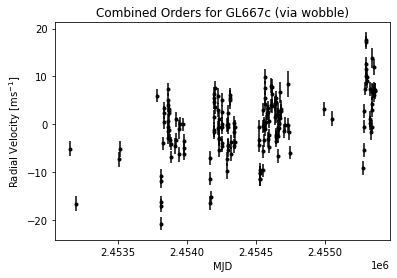

In [24]:
rvs = np.array(results['RV'] - np.median(results['RV'])) #combined orders RVs from Wobble
rvs_err = np.array(results['RV_err']) #combined orders RV errors from Wobble
plt.figure()
plt.errorbar(times, rvs, rvs_err, fmt='.k')
plt.title('Combined Orders for {}'.format(star_name))
plt.ylabel('Radial Velocity [ms$^{-1}$]')
plt.xlabel('MJD')

### Fitting a linear trend to these RVs and subtracting it.

I will use scipy optimize curve fit (I previously used astropy but found it cumbersome, especially to get out the popt/pcov matrices). Start by defining a straight line function and then find the best fit based on the data, and return the popt and pcov matrices and therefore the perr.

- **NOTE - how can I get -1 in the superscript of the unit in the label without it getting confused with the dot formatting {}**

In [ ]:
def straight_line (x, m, c):
    return (m * x) + c

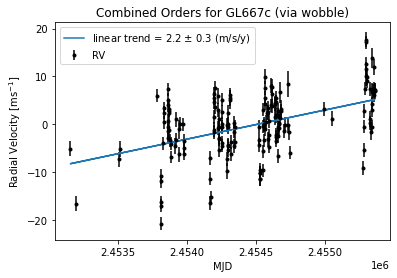

In [62]:
popt, pcov = curve_fit(straight_line, times, rvs, sigma = rvs_err)
perr = np.sqrt(np.diag(pcov))
trend_year_rounded = np.around((popt[0]*365.25), decimals = 1)
trend_year_rounded_err = np.around((perr[0]*365.25), decimals = 1)
plt.figure()
plt.errorbar(times, rvs, rvs_err, fmt='.k', label='RV')
plt.plot(times, straight_line(times, popt[0], popt[1]), label='linear trend = {0} $\pm$ {1} (m/s/y)'.format(trend_year_rounded, trend_year_rounded_err))
plt.title('Combined Orders for {}'.format(star_name))
plt.ylabel('Radial Velocity [ms$^{-1}$]')
plt.xlabel('MJD')
plt.legend()


### Detrending the RVs for the combined orders

I do this by subtracting the fit from the RVs, I then check that it has worked correctly by fitting a line to the resulting data and verifying that it has a gradient of zero.

In [65]:
detrended = [rvs[i] - (straight_line(times, popt[0], popt[1]))[i] for i in range(0, len(times))]

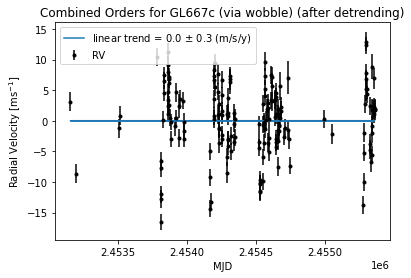

In [74]:
popt_detrended, pcov_detrended = curve_fit(straight_line, times, detrended, sigma = rvs_err)
perr_detrended = np.sqrt(np.diag(pcov_detrended))
detrended_year_rounded = np.around((popt_detrended[0]*365.25), decimals = 1)
detrended_year_rounded_err = np.around((perr_detrended[0]*365.25), decimals = 1)
plt.figure()
plt.errorbar(times, detrended, rvs_err, fmt='.k', label='RV')
plt.plot(times, straight_line(times, popt_detrended[0], popt_detrended[1]), label='linear trend = {0} $\pm$ {1} (m/s/y)'.format(detrended_year_rounded, detrended_year_rounded_err))
plt.title('Combined Orders for {} (after detrending)'.format(star_name))
plt.ylabel('Radial Velocity [ms$^{-1}$]')
plt.xlabel('MJD')
plt.legend()


As expected, the detrended RVs have a trend of 0, so I will now use the same original trend and subtract it from each order to see if there is a residual trend that appears in each order.

## Order by Order
### Identifying the orders / epochs that have NaN in the RV errors

I noticed that some of the RV errors had NaN in, which made fitting for the trend in each difficult. I need to identify the orders and the epochs that these come from, to be able to do further analysis.

Below I create an order by epoch boolean array where if the value of RV_err is NaN the element in the array is True.

### Replacing the NaN values in the order by order RV_errs with np.inf in order to be able to fit the trend properly.

to do this going to slice each order of rvs_err with the boolean mask I created before and assign it to np.inf.

In [79]:
no_of_orders = len(results_hdf5.orders) #number of orders in the results - note, doesn't give which order, I need to get this from the data, but lower numbers are the blue wavelengths
no_of_epochs = len(results_hdf5.epochs) #number of epochs
no_of_elements = no_of_epochs * no_of_orders #total number of elements to give an idea of how many NaNs there are

nan_rvs_err = [] #preassigning an empty list to the nan_rv_errs
rvs_err_inf = [] #preassigning an empty list to save the rvs_errs that have had NaNs replaced with np.inf

for o in range(no_of_orders):
    order_rvs_err = np.array(results['RV_order{}_err'.format(o)]) #getting the uncertainties in the same way
    nan_rvs_err.append(np.isnan(order_rvs_err)) #assigning the locations of the NaN in the order to the list
    #print('Order {0} has {1} out of 172 epochs as NaN ({2}%)'.format(o, np.count_nonzero(np.isnan(order_rvs_err)),np.count_nonzero(np.isnan(order_rvs_err))*100/172)) #checking to see how many NaNs there were before
    order_rvs_isnans = np.isnan(order_rvs_err) #creating a boolean mask for the elements that have NaN
    order_rvs_err[order_rvs_isnans] = np.inf #replacing the elements using the mask with np.inf
    #print('Order {0} has {1} out of 172 epochs as NaN ({2}%)'.format(o, np.count_nonzero(np.isnan(order_rvs_err)),np.count_nonzero(np.isnan(order_rvs_err))*100/172)) #making sure the cleaning the previous 2 lines worked
    rvs_err_inf.append(order_rvs_err)

nan_rvs_err = np.array(nan_rvs_err)
rvs_err = np.array(rvs_err_inf)
    

### Detrending each order by using the combined orders trend
Each order has the overall trend from the combined orders subtracted and the residual trend calculated.

In [115]:
residual_trends = []
residual_trends_err = []
detrended_rvs_all_orders = []

for o in range(no_of_orders):
    order_rvs = np.array(results['RV_order{}'.format(o)])
    order_rvs = order_rvs - np.median(order_rvs)
    order_rvs_err = rvs_err[o,:]
    order_detrended_rvs = [order_rvs[i] - (straight_line(times, popt[0], popt[1]))[i] for i in range(0, len(times))]
    popt_order, pcov_order = curve_fit(straight_line, times, order_detrended, sigma = order_rvs_err)
    perr_order = np.sqrt(np.diag(pcov_order))
    # plt.figure()
    # plt.errorbar(times, order_detrended_rvs, order_rvs_err, fmt='.k', label='RV')
    residual_trends.append(popt_order[0])
    residual_trends_err.append(perr_order[0])
    detrended_rvs_all_orders.append(order_detrended_rvs)

# plt.figure()
# plt.errorbar(times, test_order_detrended, test_order_rvs_err, fmt='.k', label='RV')
# plt.plot(times, straight_line(times, popt_order[0], popt_order[1]), label='residual trend = {0} $\pm$ {1} (m/s/y)'.format(order_trend_rounded, order_trend_rounded_err))
# plt.title('Order X for {} (after detrending)'.format(star_name))
# plt.ylabel('Radial Velocity [ms$^{-1}$]')
# plt.xlabel('MJD')
# plt.legend()

residual_trends = np.array(residual_trends)
residual_trends_err = np.array(residual_trends_err)
detrended_rvs_all_orders = np.array(detrended_rvs_all_orders)

### Looking at the residual trend for each order

They are all negative, and after the first ~15 orders they start to converge on about -2m/s/y meaning what exactly? That I have made a mistake? That I have double counted something?

<ErrorbarContainer object of 3 artists>

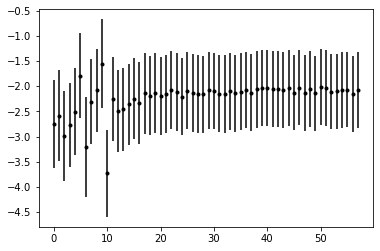

In [108]:
plt.errorbar(range(no_of_orders), residual_trends*365.25, residual_trends_err*365.25, fmt='.k')

In [117]:
np.shape(detrended_rvs_all_orders)

(58, 172)

## Producing the Lomb-Scargle Periodograms for each order

In [2]:
for o in range(no_of_orders):
    frequency, power = LombScargle(times, detrended_rvs_all_orders[o,:], rvs_err[o,:]).autopower() #run the LS, get freq & power
    #plt.figure()
    #plt.plot(frequency, power) #plotting to check
    #plt.xlim(0,150)
    #plt.xlabel('frequency [days$^{-1}$]')
    #plt.ylabel('Lomb-Scargle Power')
    #plt.title("LS Periodogram for {0}".format(star_name))

NameError: name 'no_of_orders' is not defined